# TITANIC CLASSIFICATION

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Load dataset(use the Seaborn library to load the dataset directly.)
titanic_df = sns.load_dataset('titanic')

In [2]:
# Display the first few rows of the dataframe
print(titanic_df.head())


   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  


In [3]:
# Display basic statistics of the dataframe
print(titanic_df.describe())

         survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


In [4]:
# Display the info of the dataframe to understand the data types and missing values
print(titanic_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None


## The Visualizations showing the survial rates based on different factors:

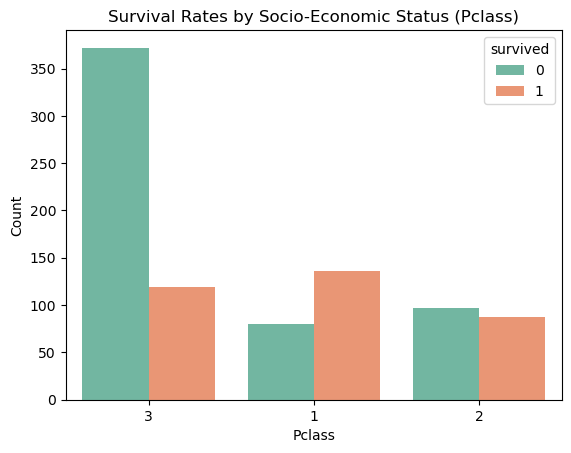

In [5]:
# Convert integer column to string
titanic_df['pclass'] = titanic_df['pclass'].astype(str)
titanic_df['survived'] = titanic_df['survived'].astype(str)

# Set the background color to white for better visibility
plt.figure(facecolor='white')

# Plot the survival rate by socio-economic status (Pclass) with custom colors
sns.countplot(x='pclass', hue='survived', data=titanic_df, palette='Set2')
plt.title('Survival Rates by Socio-Economic Status (Pclass)')
plt.xlabel('Pclass')
plt.ylabel('Count')

plt.show()

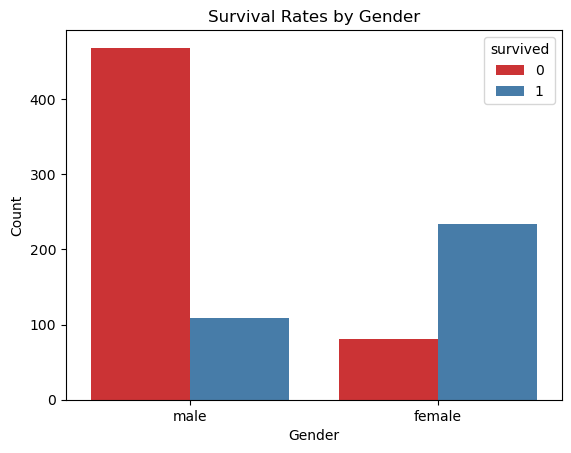

In [6]:
# Plot the survival rate by gender with custom colors
plt.figure(facecolor='white')

# Plot the survival rate by gender with custom colors
sns.countplot(x='sex', hue='survived', data=titanic_df, palette='Set1')
plt.title('Survival Rates by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.show()

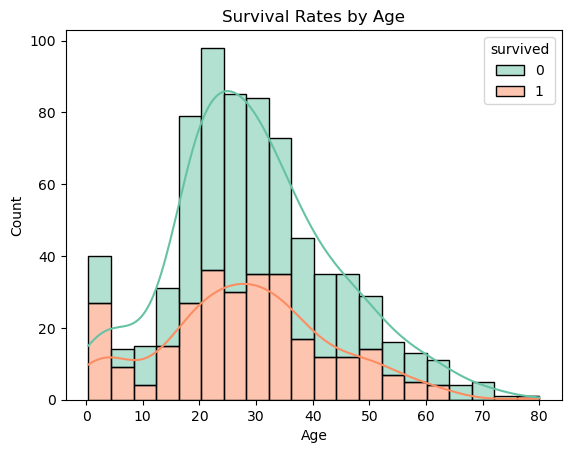

In [7]:
# Suppress the specific FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

# Plot the survival rate by age with custom colors
plt.figure(facecolor='white')

# Use histplot for age distribution with KDE curve and stacked histograms
sns.histplot(x='age', hue='survived', data=titanic_df, multiple='stack', kde=True, palette='Set2')
plt.title('Survival Rates by Age')
plt.xlabel('Age')
plt.ylabel('Count')

plt.show()


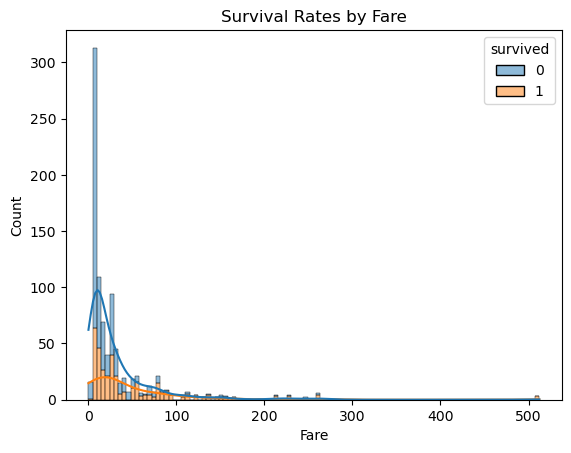

In [8]:
# Plot the survival rate by fare
plt.figure(facecolor='white')

# Use histplot for survival rate by fare
sns.histplot(x='fare', hue='survived', data=titanic_df, multiple='stack', kde=True,)
plt.title('Survival Rates by Fare')
plt.xlabel('Fare')
plt.ylabel('Count')

plt.show()

# Data Preprocessing

## 1.Categorical Encoding

In [9]:
# Convert categorical variables using label encoding
label_enc = LabelEncoder()
titanic_df['sex'] = label_enc.fit_transform(titanic_df['sex'])
titanic_df['embarked'] = label_enc.fit_transform(titanic_df['embarked'])
titanic_df['class'] = label_enc.fit_transform(titanic_df['class'])

# Drop irrelevant columns
titanic_df.drop(['alive', 'who', 'adult_male', 'deck', 'embark_town', 'pclass', 'parch', 'sibsp', 'fare'], axis=1, inplace=True)


## 2.Feature Engineering

In [10]:
# Check if 'sibsp' and 'parch' exist in the DataFrame
print("Columns in the dataset:", titanic_df.columns)  # Print columns to verify

# Create new feature FamilySize
if 'sibsp' in titanic_df.columns and 'parch' in titanic_df.columns:
    titanic_df['FamilySize'] = titanic_df['sibsp'] + titanic_df['parch'] + 1
    print("FamilySize column created successfully.")
else:
    print("Column 'sibsp' or 'parch' not found in the DataFrame")

# Ensure 'FamilySize' was created before using it
if 'FamilySize' in titanic_df.columns:
    # Create IsAlone feature
    titanic_df['IsAlone'] = 1  # Initialize to 1
    titanic_df.loc[titanic_df['FamilySize'] > 1, 'IsAlone'] = 0  # Update to 0 if family size is greater than 1
else:
    print("'FamilySize' column not found; 'IsAlone' feature will not be created.")

# Extract Title from Name if 'name' column exists
if 'name' in titanic_df.columns:
    titanic_df['Title'] = titanic_df['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Map titles to a few categories
    titanic_df['Title'] = titanic_df['Title'].replace(
        ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss')
    titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss')
    titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs')

    # Convert title to categorical values
    label_enc = LabelEncoder()
    titanic_df['Title'] = label_enc.fit_transform(titanic_df['Title'])

    # Drop 'name' as it's no longer needed
    titanic_df.drop(['name'], axis=1, inplace=True)
else:
    print("Column 'name' not found in the DataFrame")

# Check the first few rows to ensure everything is correct
print(titanic_df.head())

Columns in the dataset: Index(['survived', 'sex', 'age', 'embarked', 'class', 'alone'], dtype='object')
Column 'sibsp' or 'parch' not found in the DataFrame
'FamilySize' column not found; 'IsAlone' feature will not be created.
Column 'name' not found in the DataFrame
  survived  sex   age  embarked  class  alone
0        0    1  22.0         2      2  False
1        1    0  38.0         0      0  False
2        1    0  26.0         2      2   True
3        1    0  35.0         2      0  False
4        0    1  35.0         2      2   True


# Train-Test Split

In [11]:
# Ensure that all features are numeric
# Define features (X) and target (y)
X = titanic_df.drop(['survived'], axis=1)
y = titanic_df['survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training & Random Forest Classifier

In [12]:
# Separate features and target
X = titanic_df.drop(['survived'], axis=1)
y = titanic_df['survived']

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['number']).columns

# Create transformers for numerical and categorical features
numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor that applies the correct transformer to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline with preprocessing and model training
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['sex', 'age', 'embarked', 'class'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

## Model Evaluation

Accuracy: 0.770949720670391
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.81       105
           1       0.73      0.72      0.72        74

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



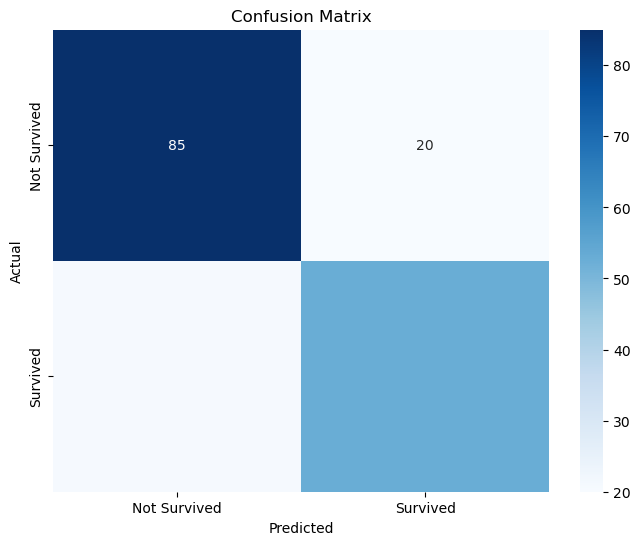

In [13]:
# Predict and evaluate the model
y_pred = pipeline.predict(X_test)

# Accuracy and Classification Report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Feature Importance Plotting

## Pipeline without onehot encoder

In [14]:

# Create transformers for numerical features (categorical features are already label encoded)
numerical_transformer = SimpleImputer(strategy='median')

# No categorical transformer is needed since encoding is done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ])

# Create the pipeline with preprocessing and model training
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)





Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['sex', 'age', 'embarked', 'class'], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [15]:
# Get feature importances
model_rf = pipeline.named_steps['classifier']
importances = model_rf.feature_importances_


In [16]:
print("Shape of feature importances:", importances.shape)
print("Number of features:", len(X_train.columns))


Shape of feature importances: (4,)
Number of features: 5


In [17]:
# Print out the features from X_train
print("Features in X_train:", X_train.columns.tolist())

# Print out the shape of X_train to understand the feature layout
print("Shape of X_train after preprocessing:", X_train.shape)

# Ensure you have the correct number of features in the X_train
relevant_columns = X_train.columns[:len(importances)]
print("Features corresponding to importances:", relevant_columns.tolist())

Features in X_train: ['sex', 'age', 'embarked', 'class', 'alone']
Shape of X_train after preprocessing: (712, 5)
Features corresponding to importances: ['sex', 'age', 'embarked', 'class']


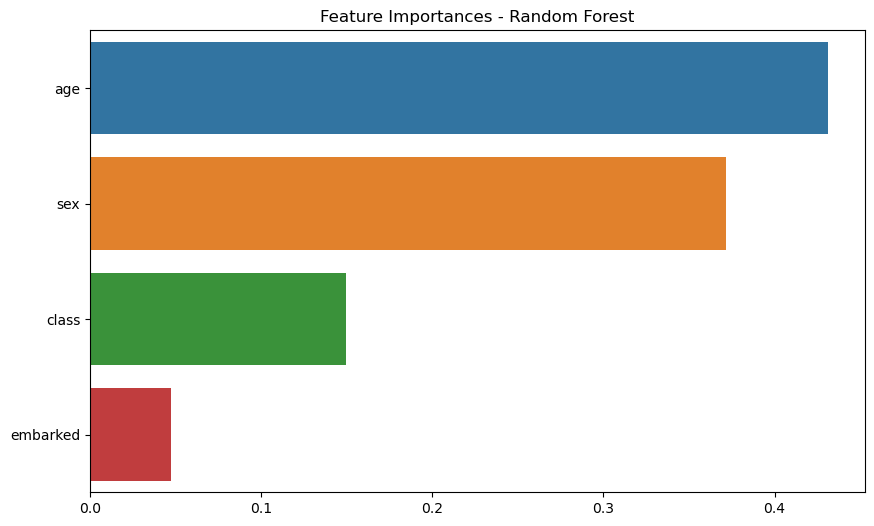

In [18]:
# Adjust the feature list to match the number of importances
relevant_columns = X_train.columns[:len(importances)]

# Plot feature importances
feature_importances = pd.Series(importances, index=relevant_columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances - Random Forest')
plt.show()